In [2]:
import pandas as pd
import numpy as np
import stock_analysis
import matplotlib.pyplot as plt
import yfinance as yfin
import pandas_datareader.data as web
from stock_analysis.utils import label_sanitizer
from datetime import datetime

In [ ]:
yfin.pdr_override()

In [ ]:
fb, aapl, amzn, nflx, goog, bitcoin, sp500 = (pd.read_csv('./data/' + ticker, parse_dates = True).assign(date = lambda x: pd.to_datetime(x.date, format = '%Y-%m-%d')).set_index('date') 
                              for ticker in ['facebook.csv', 'apple.csv', 'amazon.csv', 'netflix.csv', 'google.csv', 'bitcoin.csv', 'sp500.csv']
                             )

In [ ]:
stock_dict = {'Facebook': fb, 'Apple':aapl, 'Amazon': amzn, 'Netflix':nflx, 'Google': goog}
faang = stock_analysis.utils.group_stocks(stock_dict)

In [ ]:
sp500_reindexed = sp500.reindex(bitcoin.index).assign(
    volume = lambda x: x.volume.fillna(0),
    close = lambda x: x.close.fillna(method = 'ffill'),
    open = lambda x: np.where(x.open.isnull(), x.close, x.open),
    high = lambda x: np.where(x.high.isnull(), x.close, x.high),
    low = lambda x: np.where(x.low.isnull(), x.close, x.low)
)

start, end = '2019-01-01', '2020-12-31'
sp500_reindexed = sp500.reindex(pd.date_range(start, end=end, freq='D')).assign(
    volume = lambda x: x.volume.fillna(0),
    close = lambda x: x.close.fillna(method = 'ffill'),
    open = lambda x: x.open.combine_first(x.close),
    high = lambda x: x.high.combine_first(x.close),
    low = lambda x: x.low.combine_first(x.close)
)

In [ ]:
bitcoin_sp500 = stock_analysis.utils.group_stocks({'Bitcoin': bitcoin, 'S&P500':sp500_reindexed})

# Chapter 7 Exercises

1. Using the `StockAnalyzer` and `StockVisualizer` classes, calculate and plot three levels of support and resistance for Netflix's closing price.

In [ ]:
nflx_viz = stock_analysis.StockVisualizer(nflx)
nflx_analyze = stock_analysis.StockAnalyzer(nflx)

ax = nflx_viz.evolution_over_time('close')

support_levels = [nflx_analyze.support(level) for level in range(1,4)]
resistance_levels = [nflx_analyze.resistance(level) for level in range(1,4)]
line = [':', '-.', '--']

for (support, resist, line) in zip(support_levels, resistance_levels, line):
    nflx_viz.add_reference_line(ax, y = support, linestyle = line, color = 'green')
    nflx_viz.add_reference_line(ax, y = resist, linestyle = line, color = 'red')


2. With the `StockVisualizer` class, look at the effect of after-hours trading on the FAANG stocks:
   1. As individual stocks
   2. As a portfolio using the `make_portfolio()` function from the `stock_analysis.utils` module

In [ ]:
stocks = [fb, aapl, amzn, nflx, goog]
stock_label = ['Facebook', 'Apple', 'Amazon', 'Netflix', 'Google']

for (stock_name, ticker) in stock_dict.items():
    ax = stock_analysis.StockVisualizer(ticker).after_hours_trades()
    ax[0].set_title(f'After-hours trading for {stock_name}\n(Open Price - Prior Day\'s Close)')
    ax[1].set_title(f'After-hours trading monthly effect for {stock_name}')

In [ ]:
portfolio = stock_analysis.utils.make_portfolio(faang)
faang_viz = stock_analysis.StockVisualizer(portfolio)
ax = faang_viz.after_hours_trades()

3. Using the `StockVisualizer.open_to_close()` method, create a plot that fills the area between the FAANG stocks' opening price (as a portfolio) and its closing price each day in red if the price declined and in green if the price increased. As a bonus, do the same for a portfolio of bitcoin and the S&P 500.

In [ ]:
ax = faang_viz.open_to_close()

In [ ]:
bitcoin_sp500_portfolio = stock_analysis.utils.make_portfolio(bitcoin_sp500)
ax = stock_analysis.StockVisualizer(bitcoin_sp500_portfolio).open_to_close()

4. Mutual funds and **exchange-traded funds (ETFs)** are funds that are composed of many assets. They are built to mitigate risk, so volatility for the fund will be lower than that of the assets that compose it. (Information on how they differ can be found at https://www.investopedia.com/articles/exchangetradedfunds/08/etf-mutual-fund-difference.asp.) Compare a mutual fund or ETF of your choice to three of its largest stocks (by composition) using annualized volatility and the `AssetGroupAnalyzer` class.

In [ ]:
@label_sanitizer
def get_ticker_data_updated(ticker, start, end):
    return web.get_data_yahoo(ticker, start, end)

In [ ]:
ticker = 'VOO'
voo = get_ticker_data_updated(ticker, start = '2019-01-01', end = '2020-12-31')

In [ ]:
msft = get_ticker_data_updated('MSFT', start = '2019-01-01', end = '2020-12-31')
voo_top3 = {'VOO': voo,
            'Apple': aapl, 
            'Microsoft': msft, 
            'Amazon': amzn
           }
voo_grouped = stock_analysis.utils.group_stocks(voo_top3)

In [ ]:
voo_analyzer = stock_analysis.AssetGroupAnalyzer(voo_grouped)
voo_analyzer.analyze('annualized_volatility')

5. Write a function that returns a dataframe of one row with columns for `alpha`, `beta`, `sharpe_ratio`, `annualized_volatility`, `is_bear_market`, and `is_bull_market`, which each contain the results of running the respective methods on a given stock using the `StockAnalyzer` class. Dictionary comprehensions and the `getattr()` function, as used in the `AssetGroupAnalyzer.analyze()` method, will be useful.

In [ ]:
r_f = 0.93

In [ ]:
def stock_analytics(stock):
    stock_analyzer = stock_analysis.StockAnalyzer(stock)
#    return {
#        func_name: getattr(stock_analyzer, func)(**kwargs) for (func_name, func) in {'alpha': ('alpha', index=sp500, r_f=r_f)}
#    }
    return pd.DataFrame.from_dict({'name':'MSFT',
                                   'alpha': [stock_analyzer.alpha(index = sp500, r_f = r_f)],
                                   'beta': [stock_analyzer.beta(index = sp500)],
                                   'sharpe_ratio': [stock_analyzer.sharpe_ratio(r_f = r_f)],
                                   'annualized_volatility': [stock_analyzer.annualized_volatility()],
                                   'is_bear_market': [stock_analyzer.is_bear_market()],
                                   'is_bull_market': [stock_analyzer.is_bull_market()]
                                  }
                                 ).set_index('name')


In [ ]:
#def stock_analytics(stock):
#    stock_analyzer = stock_analysis.StockAnalyzer(stock)
#    return {
#        func_name: getattr(stock_analyzer, func)(**kwargs) for (func_name, func) in {'alpha': ('alpha', index=sp500, r_f=r_f)}
#    }
#    return {'alpha': getattr(stock_analyzer, ('alpha', index = sp500, r_f = r_f))}

In [ ]:
stock_analytics(msft)

6. With the `StockModeler` class, build an ARIMA model fit on the S&P 500 data from January 1, 2019 through November 30, 2020 and use it to predict the performance in December 2020. Be sure to examine the residuals and compare the predicted performance to the actual performance.

In [ ]:
sp_arima = stock_analysis.StockModeler.arima(sp500, ar=10, i = 1, ma = 5)

In [ ]:
stock_analysis.StockModeler.plot_residuals(sp_arima)

In [ ]:
fig, ax = plt.subplots()

arima_ax = stock_analysis.StockModeler.arima_predictions(sp500, sp_arima, start = '2019-01-02', end = '2020-12-31', ax = ax, title = 'ARIMA', color = 'b')
sp500.close.plot(ax = arima_ax, style = 'b--', label = 'actual close')
arima_ax.legend()
arima_ax.set_ylabel('price ($)')

7. Request an API key for AlphaVantage (https://www.alphavantage.co/support/#api-key) and collect the daily foreign exchange rate from USD to JPY using the `get_forex_rates()` method on the same `StockReader` object you created to collect the data for the previous exercises. Build a candlestick plot with the data from February 2019 through January 2020, resampled to 1-week intervals. Hint: take a look at the `slice()` function from the standard library (https://docs.python.org/3/library/functions.html#slice) in order to provide the date range.

In [3]:
api_key = 'QQFTDCW4MTTCMLR1'
usd_to_jpy = stock_analysis.StockReader('2019-01-01', '2020-12-31').get_forex_rates(from_currency = 'USD', to_currency = 'JPY', api_key = api_key)

In [4]:
usd_to_jpy_viz = stock_analysis.StockVisualizer(usd_to_jpy)

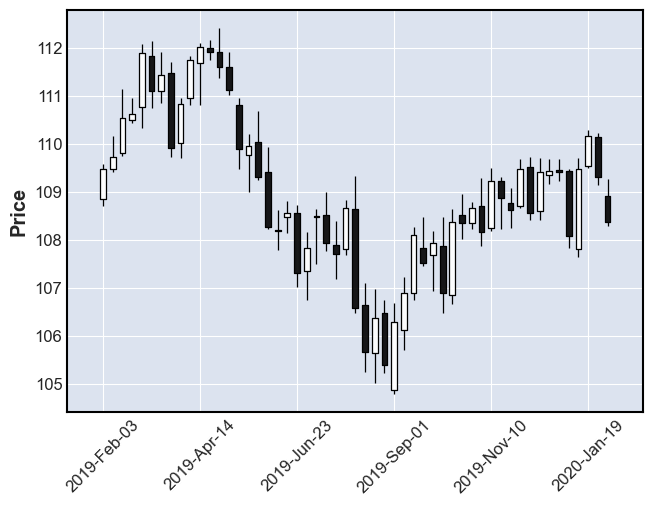

In [5]:
usd_to_jpy_viz.candlestick(date_range = slice('2019-02-01','2020-01-31'), resample = '1W')